In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import re
import json
sns.set()

In [153]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lumos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [154]:
df = pd.read_csv("./data/output.csv", delimiter="\t")

In [155]:
rating_pattern = re.compile(r"((- ?)?\d+)/10")

In [156]:
def is_rating(tweet):
    match = rating_pattern.search(tweet)
    return match is not None

In [157]:
def get_rating(tweet):
    match = rating_pattern.search(tweet)
    return int("".join(match.group(1).split()))

In [158]:
def strip_ratings(tweet):
    tweet = re.sub(rating_pattern, "", tweet)
    tweet = re.sub("[Mm]inus", "", tweet)
    return tweet

In [159]:
def strip_links(tweet):
    tweet = re.sub("https?://t.co/\w+", "", tweet)
    return tweet

In [160]:
with open('stopwords', 'r') as f:
    stopwords = f.readlines()
    stopwords.extend(["room", "rater"])
    stopwords = {word.strip() for word in stopwords}

In [161]:
def strip_stopwords(tweet):
    tweet_list = tweet.split()
    return ' '.join([i for i in tweet_list if i not in stopwords])

In [162]:
# Strip out punctuation at end of words and make every word lowercase
def strip_end_punctuation_and_lower(tweet):
    tweet_list = tweet.split()
    return ' '.join([i.lower().rstrip(string.punctuation) for i in tweet_list])

In [163]:
def bigramed(tweet):
    token = nltk.word_tokenize(tweet)
    bigrams = ngrams(token, 2)
    return ' '.join([i[0]+i[1] for i in bigrams])

In [164]:
def preprocess_tweet(tweet):
    tweet = strip_ratings(tweet)
    tweet = strip_links(tweet)
    return tweet

In [165]:
def preprocess_tweet_stopwords(tweet):
    tweet = strip_ratings(tweet)
    tweet = strip_links(tweet)
    tweet = strip_end_punctuation_and_lower(tweet)
    tweet = strip_stopwords(tweet)
    return tweet

In [181]:
len(df)

19353

In [169]:
df["is_rating_tweet"] = df.tweet.apply(is_rating)
rating_tweets = df[df["is_rating_tweet"] & df["reply_to"].eq("[]")]
rating_tweets["rating"] = rating_tweets.tweet.apply(get_rating)
# rating_tweets["cleaned"] = rating_tweets.tweet.apply(strip_ratings).apply(strip_links).apply(strip_stopwords)
rating_tweets["cleaned"] = rating_tweets.tweet.apply(preprocess_tweet)
rating_tweets["no_stopwords"] = rating_tweets.tweet.apply(preprocess_tweet_stopwords)
rating_tweets["bigram"] = rating_tweets.tweet.apply(preprocess_tweet_stopwords).apply(bigramed)
rating_tweets["img_url"] = rating_tweets.photos.apply(eval).apply(lambda x: x[0] if len(x) > 0 else None)

<ipython-input-169-4b6bffdfbdbe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_tweets["rating"] = rating_tweets.tweet.apply(get_rating)
<ipython-input-169-4b6bffdfbdbe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_tweets["cleaned"] = rating_tweets.tweet.apply(preprocess_tweet)
<ipython-input-169-4b6bffdfbdbe>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [173]:
rating_tweets[[
    "rating",
    "cleaned",
    "no_stopwords",
    "bigram",
    "tweet",
    "created_at",
    "replies_count",
    "retweets_count",
    "likes_count",
    "img_url"
]].to_csv("data/cleaned.csv", index=False)

In [182]:
len(rating_tweets)

12619

In [174]:
rating_tweets["img_url"].to_csv("data/images.csv", index=False)

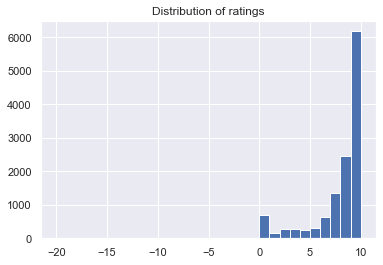

In [175]:
plt.figure()
plt.title("Distribution of ratings")
rating_tweets.rating.sort_values()[:-1].hist(bins=30)
plt.savefig("./figures/rating_distribution.pdf")

In [176]:
rating_tweets.rating.describe()

count    12619.000000
mean         7.625485
std          2.940338
min        -20.000000
25%          7.000000
50%          8.000000
75%         10.000000
max        100.000000
Name: rating, dtype: float64

In [177]:
rating_tweets["cleaned"][6]

'Doors of Dublin. The Dingus-the stuff that dreams are made of. Nice pineapple. Old school distributer lamp.  #jimcavanaugh  '

In [179]:
rating_tweets["no_stopwords"][6]

'doors dublin dingus-the stuff dreams made nice pineapple old school distributer lamp #jimcavanaugh'

In [180]:
rating_tweets["bigram"][6]

'doorsdublin dublindingus-the dingus-thestuff stuffdreams dreamsmade madenice nicepineapple pineappleold oldschool schooldistributer distributerlamp lamp# #jimcavanaugh'